MSiA 421 Final Project -- Spotify Track Recommender System

03/08/2023

Betty Chen, Cindy Chen, Jade Cao, and Michelle Liu

In [ ]:
!pip install kmodes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install TextBlob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from textblob import TextBlob
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px 

import warnings
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option("display.max_columns", None)

# Read Data

In [ ]:
spotify = pd.read_csv("spotify.csv")

In [ ]:
spotify.head()

Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610    1    -6.746     0       0.1430        0.0322   
1         0.420  0.1660    1   -17.235     1       0.0763        0.9240   
2         0.438  0.3590    0    -9.734     1       0.0557        0.2100   
3         0.266  0.0596    0   -18.515     1       0.0363        0.9050   
4         0.618  0.4430    2    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature track_genre  
0          0.000001    0.3580    0.715   87.917             4.0    acoustic  
1          0.000006    0.1010    0.267   77.489             4.0    acoustic  
2          0.000000    0.1170    0.120   76.332             4.0    acoustic  
3          0.000071    0.1320    0.143  181.740             3.0    acoustic  
4          0.000000    0.0829    0.167  119.949             4.0    acoustic

In [ ]:
spotify_new = spotify.drop(columns=["Unnamed: 0", "track_id", "explicit", "key", "mode", "time_signature"])

In [ ]:
spotify_new.head()

artists                                         album_name  \
0             Gen Hoshino                                             Comedy   
1            Ben Woodward                                   Ghost (Acoustic)   
2  Ingrid Michaelson;ZAYN                                     To Begin Again   
3            Kina Grannis  Crazy Rich Asians (Original Motion Picture Sou...   
4        Chord Overstreet                                            Hold On   

                   track_name  popularity  duration_ms  danceability  energy  \
0                      Comedy          73       230666         0.676  0.4610   
1            Ghost - Acoustic          55       149610         0.420  0.1660   
2              To Begin Again          57       210826         0.438  0.3590   
3  Can't Help Falling In Love          71       201933         0.266  0.0596   
4                     Hold On          82       198853         0.618  0.4430   

   loudness  speechiness  acousticness  instrumentalness  liveness  valence  \
0    -6.746       0.1430        0.0322          0.000001    0.3580    0.715   
1   -17.235       0.0763        0.9240          0.000006    0.1010    0.267   
2    -9.734       0.0557        0.2100          0.000000    0.1170    0.120   
3   -18.515       0.0363        0.9050          0.000071    0.1320    0.143   
4    -9.681       0.0526        0.4690          0.000000    0.0829    0.167   

     tempo track_genre  
0   87.917    acoustic  
1   77.489    acoustic  
2   76.332    acoustic  
3  181.740    acoustic  
4  119.949    acoustic

# EDA

In [ ]:
spotify_new.isnull().sum()

artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
danceability        0
energy              0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
track_genre         1
dtype: int64

In [ ]:
spotify_new[spotify_new.isna().any(axis=1)] # check null value

artists   album_name                          track_name  \
59970  Leila Bela  Angra Manyu  Let Me Help You Mr. Monster Man...   

       popularity  duration_ms  danceability   energy  loudness  speechiness  \
59970           0        70040         0.242  0.00959   -32.735       0.0527   

       acousticness  instrumentalness  liveness  valence  tempo track_genre  
59970         0.987            0.0107     0.103     0.14  150.0         NaN

In [ ]:
spotify_new = spotify_new.dropna()#drop nan value

In [ ]:
spotify_new.isna().sum()

artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
danceability        0
energy              0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
track_genre         0
dtype: int64

In [ ]:
# check data type
spotify_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59970 entries, 0 to 59969
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artists           59970 non-null  object 
 1   album_name        59970 non-null  object 
 2   track_name        59970 non-null  object 
 3   popularity        59970 non-null  int64  
 4   duration_ms       59970 non-null  int64  
 5   danceability      59970 non-null  float64
 6   energy            59970 non-null  float64
 7   loudness          59970 non-null  float64
 8   speechiness       59970 non-null  float64
 9   acousticness      59970 non-null  float64
 10  instrumentalness  59970 non-null  float64
 11  liveness          59970 non-null  float64
 12  valence           59970 non-null  float64
 13  tempo             59970 non-null  float64
 14  track_genre       59970 non-null  object 
dtypes: float64(9), int64(2), object(4)
memory usage: 7.3+ MB


In [ ]:
spotify_new_num = spotify_new.drop(columns=["artists", "album_name", "track_name", "track_genre"])

In [ ]:
# scale all numeric predictors
from sklearn.preprocessing import StandardScaler

# create a scaler object
std_scaler = StandardScaler()
#std_scaler
# fit and transform the data
df_std = pd.DataFrame(std_scaler.fit_transform(spotify_new_num), columns=spotify_new_num.columns)

df_std

popularity  duration_ms  danceability    energy  loudness  speechiness  \
0        1.808872     0.001890      0.648056 -0.786103  0.280153     0.403580   
1        1.004392    -0.694715     -0.805662 -1.958998 -1.834674    -0.128602   
2        1.093779    -0.168617     -0.703448 -1.191646 -0.322297    -0.292965   
3        1.719485    -0.245045     -1.680165 -2.382035 -2.092751    -0.447752   
4        2.211111    -0.271515      0.318698 -0.857669 -0.311611    -0.317699   
...           ...          ...           ...       ...       ...          ...   
59965   -1.453740     1.053244     -0.203732  0.506069  0.125508    -0.513976   
59966   -1.453740     2.080242     -0.697769  0.521973 -0.559406     1.321137   
59967   -1.453740    -1.694814     -1.589307 -0.635018 -0.507993     0.116345   
59968   -1.364353     0.015185     -2.253702 -0.372608 -0.736633    -0.421423   
59969   -1.453740     3.932276      0.489055 -1.132008 -1.833464     0.220069   

       acousticness  instrumentalness  liveness   valence     tempo  
0         -0.767954         -0.567650  0.815127  1.044865 -1.200414  
1          1.960113         -0.567636 -0.588357 -0.710781 -1.556631  
2         -0.224054         -0.567653 -0.500980 -1.286852 -1.596154  
3          1.901991         -0.567438 -0.419065 -1.196718  2.004552  
4          0.568242         -0.567653 -0.687201 -1.102666 -0.106210  
...             ...               ...       ...       ...       ...  
59965     -0.865486          1.946760 -0.566513 -0.761726 -0.103819  
59966      0.656955          1.904143  0.793283 -0.726456  1.586983  
59967     -0.450424          2.406417  2.508045  0.045558  1.308377  
59968     -0.425951          2.251169 -0.533746 -1.188881 -1.389898  
59969      1.326888          1.937628 -0.610747 -1.137936 -0.105801  

[59970 rows x 11 columns]

In [ ]:
# Correlation between columns
df_std.corr()

popularity  duration_ms  danceability    energy  loudness  \
popularity          1.000000    -0.059184      0.072598 -0.033778  0.087394   
duration_ms        -0.059184     1.000000     -0.077878  0.061426 -0.007141   
danceability        0.072598    -0.077878      1.000000  0.056682  0.190049   
energy             -0.033778     0.061426      0.056682  1.000000  0.776523   
loudness            0.087394    -0.007141      0.190049  0.776523  1.000000   
speechiness        -0.039992    -0.041794      0.076199  0.143982  0.040054   
acousticness        0.010121    -0.105935     -0.098003 -0.743081 -0.616762   
instrumentalness   -0.171484     0.115471     -0.212828 -0.162041 -0.418603   
liveness           -0.037319     0.014032     -0.114284  0.194114  0.098588   
valence            -0.012504    -0.137527      0.492158  0.174733  0.203965   
tempo               0.003178     0.033217     -0.074803  0.243322  0.201644   

                  speechiness  acousticness  instrumentalness  liveness  \
popularity          -0.039992      0.010121         -0.171484 -0.037319   
duration_ms         -0.041794     -0.105935          0.115471  0.014032   
danceability         0.076199     -0.098003         -0.212828 -0.114284   
energy               0.143982     -0.743081         -0.162041  0.194114   
loudness             0.040054     -0.616762         -0.418603  0.098588   
speechiness          1.000000      0.061533         -0.109357  0.316598   
acousticness         0.061533      1.000000          0.105795 -0.031810   
instrumentalness    -0.109357      0.105795          1.000000 -0.095402   
liveness             0.316598     -0.031810         -0.095402  1.000000   
valence              0.016551     -0.067793         -0.279582 -0.003632   
tempo               -0.029628     -0.212088         -0.025883  0.003708   

                   valence     tempo  
popularity       -0.012504  0.003178  
duration_ms      -0.137527  0.033217  
danceability      0.492158 -0.074803  
energy            0.174733  0.243322  
loudness          0.203965  0.201644  
speechiness       0.016551 -0.029628  
acousticness     -0.067793 -0.212088  
instrumentalness -0.279582 -0.025883  
liveness         -0.003632  0.003708  
valence           1.000000  0.037972  
tempo             0.037972  1.000000

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# create a scaler object
scaler = MinMaxScaler()
# fit and transform the data
df_norm = pd.DataFrame(scaler.fit_transform(spotify_new_num), columns=spotify_new_num.columns)

df_norm

popularity  duration_ms  danceability    energy  loudness  speechiness  \
0            0.73     0.046456      0.687691  0.460989  0.757858     0.148187   
1            0.55     0.029500      0.427263  0.165983  0.532656     0.079067   
2            0.57     0.042306      0.445575  0.358987  0.693705     0.057720   
3            0.71     0.040445      0.270600  0.059581  0.505174     0.037617   
4            0.82     0.039801      0.628688  0.442989  0.694843     0.054508   
...           ...          ...           ...       ...       ...          ...   
59965        0.00     0.072047      0.535097  0.785996  0.741390     0.029016   
59966        0.00     0.097044      0.446592  0.789996  0.668456     0.267358   
59967        0.00     0.005157      0.286877  0.498990  0.673931     0.110881   
59968        0.02     0.046780      0.167854  0.564991  0.649583     0.041036   
59969        0.00     0.142124      0.659207  0.373987  0.532785     0.124352   

       acousticness  instrumentalness  liveness   valence     tempo  
0          0.032329          0.000001  0.352511  0.718593  0.361245  
1          0.927711          0.000006  0.091279  0.268342  0.318397  
2          0.210843          0.000000  0.107542  0.120603  0.313643  
3          0.908635          0.000071  0.122789  0.143719  0.746758  
4          0.470884          0.000000  0.072881  0.167839  0.492863  
...             ...               ...       ...       ...       ...  
59965      0.000318          0.826827  0.095345  0.255276  0.493150  
59966      0.500000          0.812813  0.348445  0.264322  0.696530  
59967      0.136546          0.977978  0.667615  0.462312  0.663018  
59968      0.144578          0.926927  0.101443  0.145729  0.338453  
59969      0.719880          0.823824  0.087111  0.158794  0.492912  

[59970 rows x 11 columns]

In [ ]:
# Keep a dataframe with normalized numeric columns and categorical columns
spotify_new_norm = df_norm.copy()
spotify_new_norm.insert(0, "artists", spotify_new["artists"])
spotify_new_norm.insert(1, "album_name", spotify_new["album_name"])
spotify_new_norm.insert(2, "track_name", spotify_new["track_name"])
spotify_new_norm["track_genre"] = spotify_new["track_genre"]
spotify_new_norm.head()

artists                                         album_name  \
0             Gen Hoshino                                             Comedy   
1            Ben Woodward                                   Ghost (Acoustic)   
2  Ingrid Michaelson;ZAYN                                     To Begin Again   
3            Kina Grannis  Crazy Rich Asians (Original Motion Picture Sou...   
4        Chord Overstreet                                            Hold On   

                   track_name  popularity  duration_ms  danceability  \
0                      Comedy        0.73     0.046456      0.687691   
1            Ghost - Acoustic        0.55     0.029500      0.427263   
2              To Begin Again        0.57     0.042306      0.445575   
3  Can't Help Falling In Love        0.71     0.040445      0.270600   
4                     Hold On        0.82     0.039801      0.628688   

     energy  loudness  speechiness  acousticness  instrumentalness  liveness  \
0  0.460989  0.757858     0.148187      0.032329          0.000001  0.352511   
1  0.165983  0.532656     0.079067      0.927711          0.000006  0.091279   
2  0.358987  0.693705     0.057720      0.210843          0.000000  0.107542   
3  0.059581  0.505174     0.037617      0.908635          0.000071  0.122789   
4  0.442989  0.694843     0.054508      0.470884          0.000000  0.072881   

    valence     tempo track_genre  
0  0.718593  0.361245    acoustic  
1  0.268342  0.318397    acoustic  
2  0.120603  0.313643    acoustic  
3  0.143719  0.746758    acoustic  
4  0.167839  0.492863    acoustic

# Data Visualization

In [ ]:
# We have 114 different genre in our spotify dataset and each genre contains 1000 tracks
len(set(spotify_new["track_genre"]))

60

In [ ]:
spotify_new["track_genre"].value_counts()

acoustic          1000
afrobeat          1000
electronic        1000
emo               1000
folk              1000
forro             1000
french            1000
funk              1000
garage            1000
german            1000
gospel            1000
goth              1000
grindcore         1000
groove            1000
grunge            1000
guitar            1000
happy             1000
hard-rock         1000
hardcore          1000
hardstyle         1000
heavy-metal       1000
hip-hop           1000
honky-tonk        1000
house             1000
idm               1000
indian            1000
indie-pop         1000
indie             1000
industrial        1000
electro           1000
edm               1000
dubstep           1000
children          1000
alt-rock          1000
alternative       1000
ambient           1000
anime             1000
black-metal       1000
bluegrass         1000
blues             1000
brazil            1000
breakbeat         1000
british           1000
cantopop   

<AxesSubplot:>

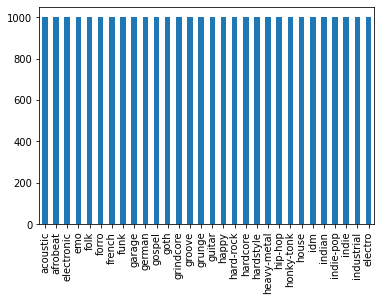

In [ ]:
spotify_new["track_genre"].value_counts()[:30].plot(kind="bar")

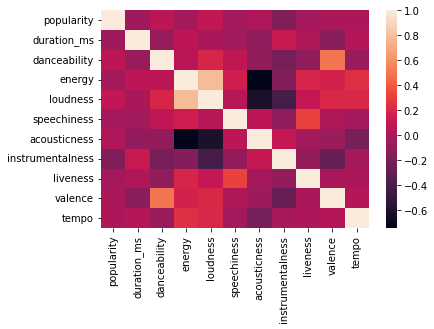

In [ ]:
corrMatrix = df_norm.corr()

sns.heatmap(corrMatrix, annot=False)
plt.show()

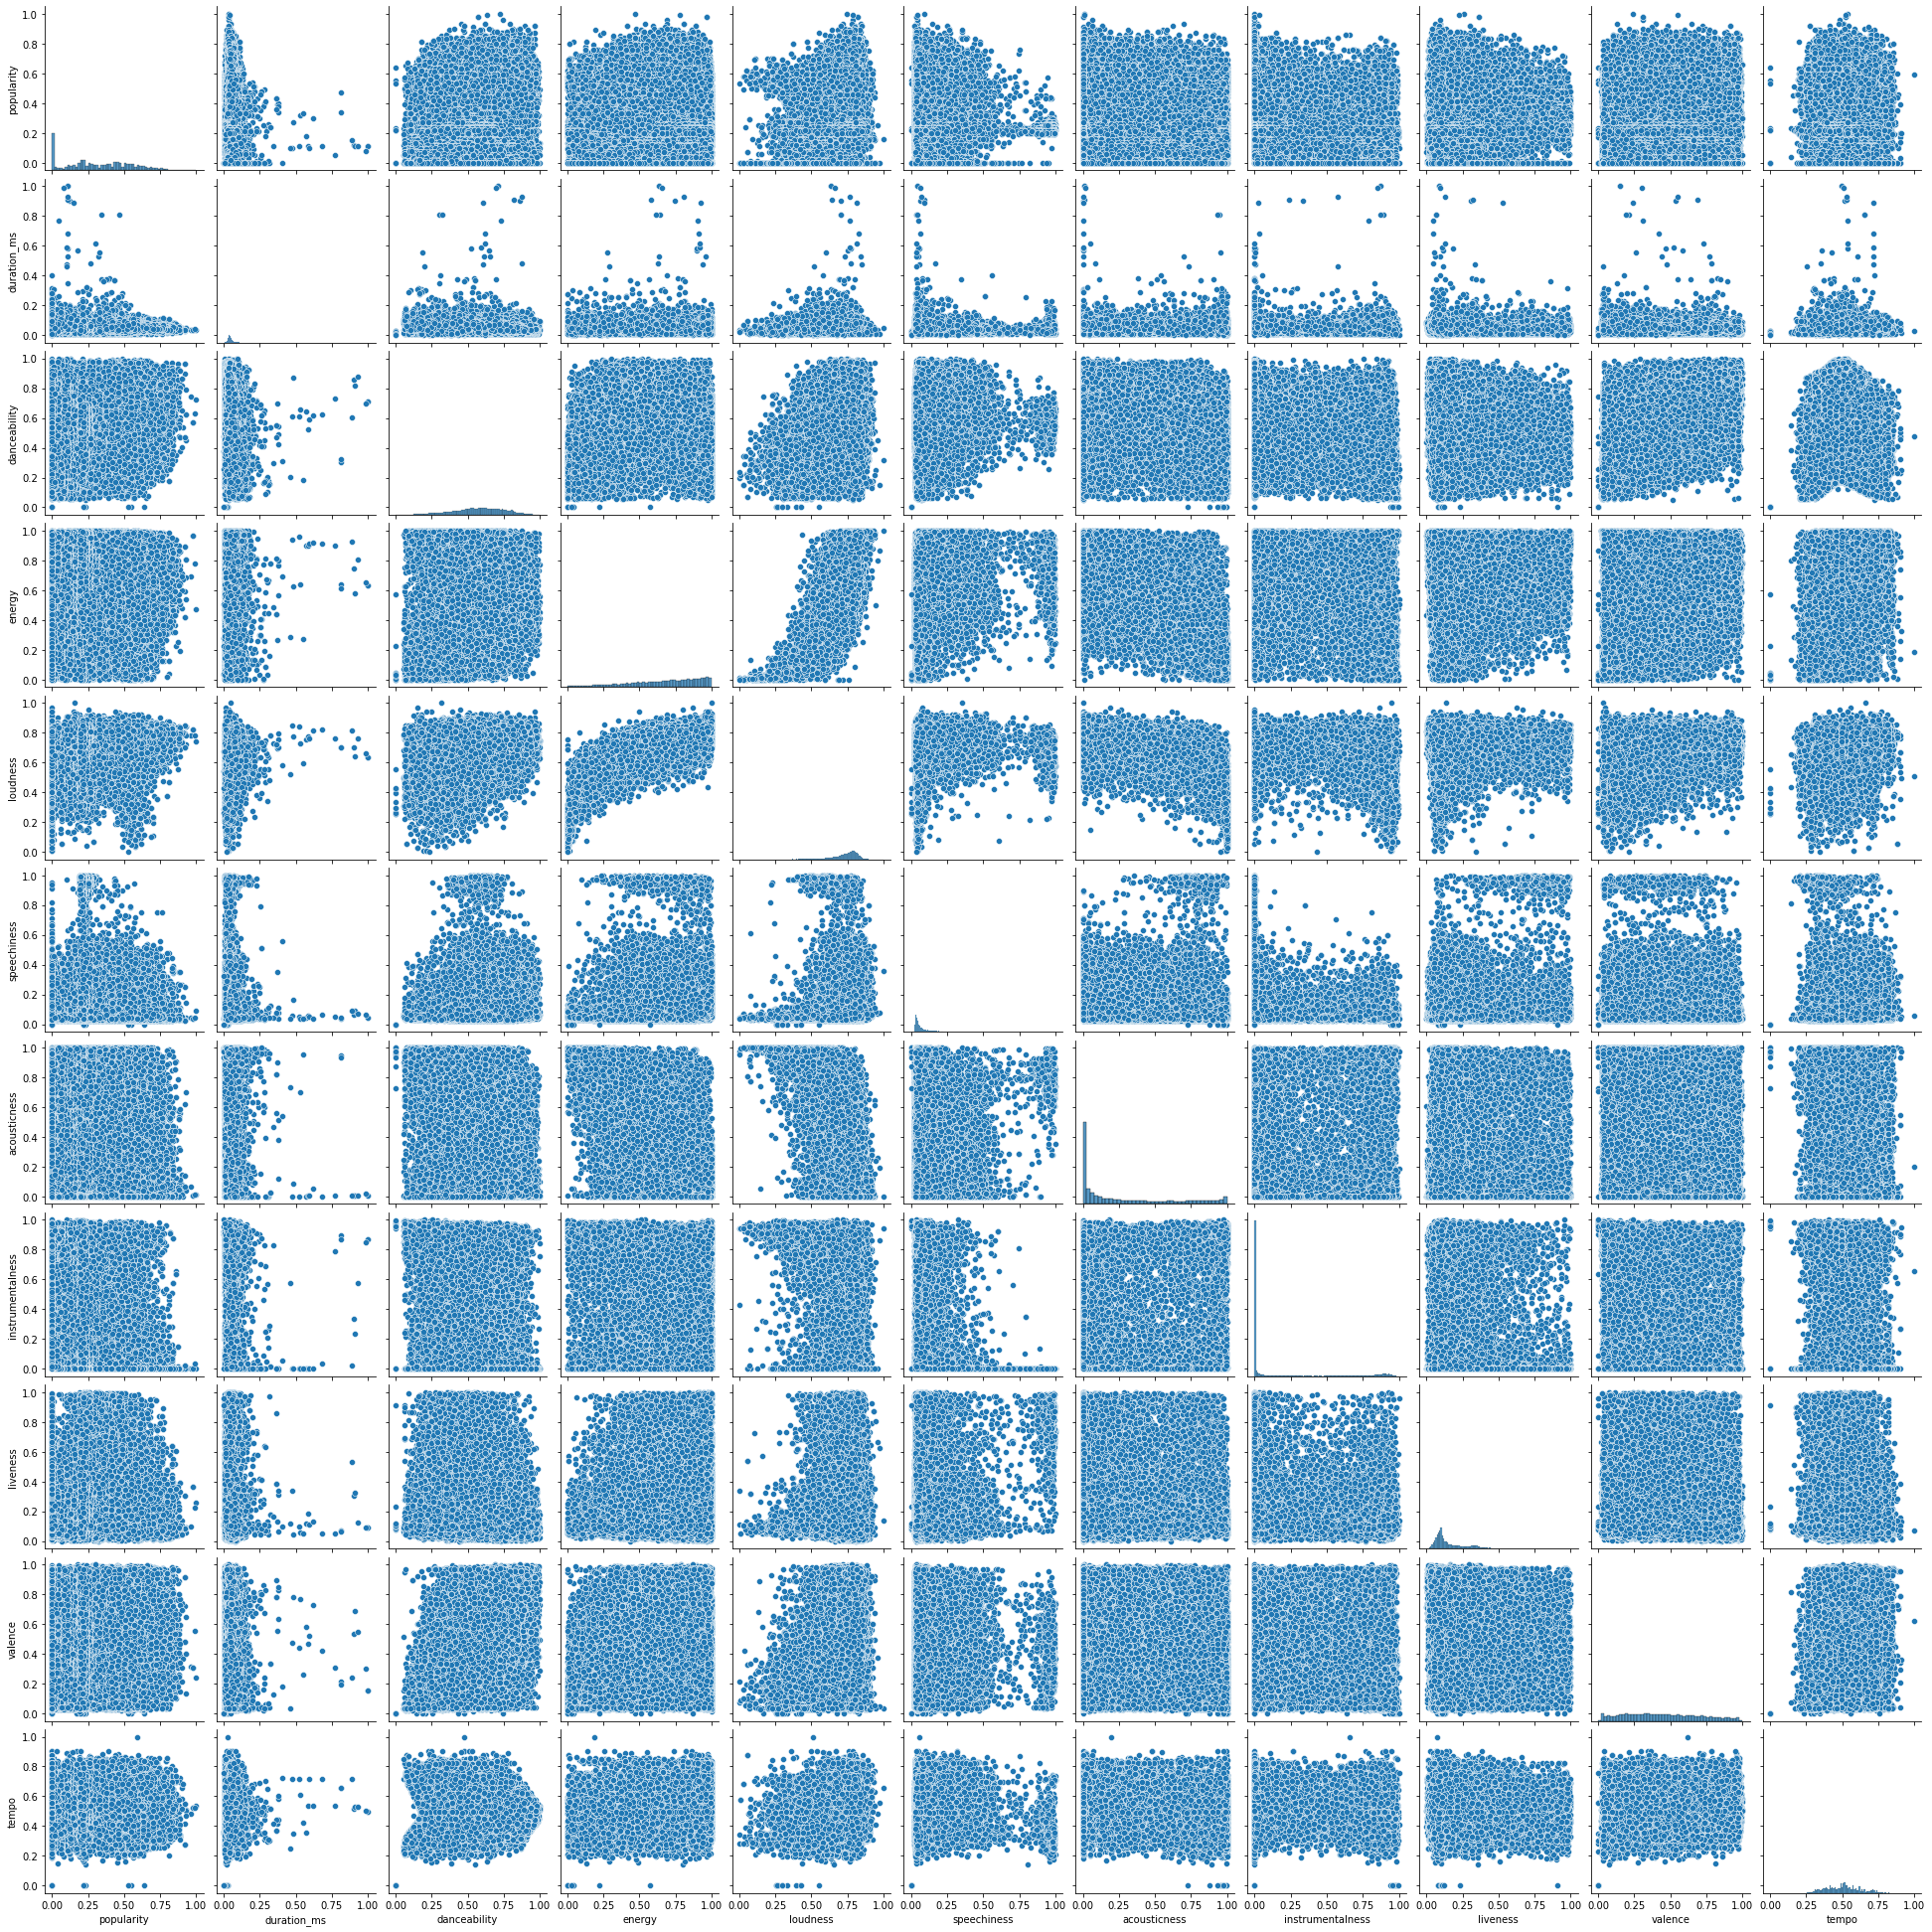

In [ ]:
sns.pairplot(df_norm)

In [ ]:
top10_genres = spotify_new_norm.nlargest(10, 'popularity')

fig = px.bar(top10_genres, x='track_genre', y=['valence', 'energy', 'danceability', 'acousticness'], barmode='group')
fig.show()


<AxesSubplot:>

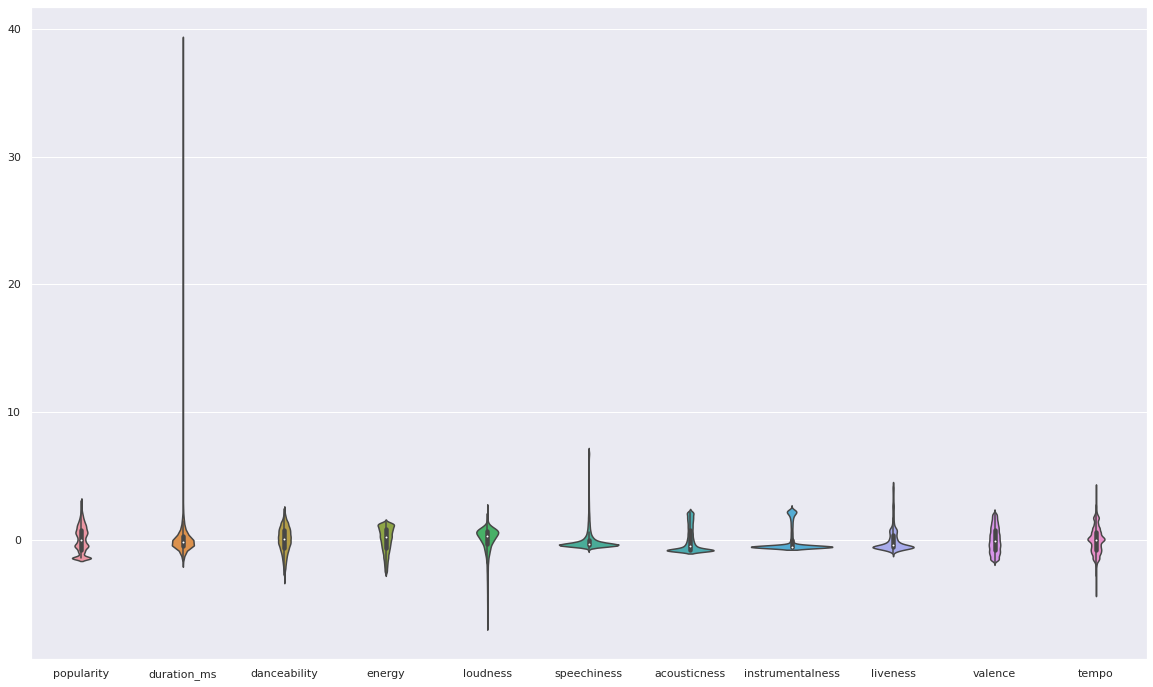

In [ ]:
#Distribution for each column with df_std
sns.set(rc={'figure.figsize':(20,12)})
sns.violinplot(data = df_std)

<AxesSubplot:>

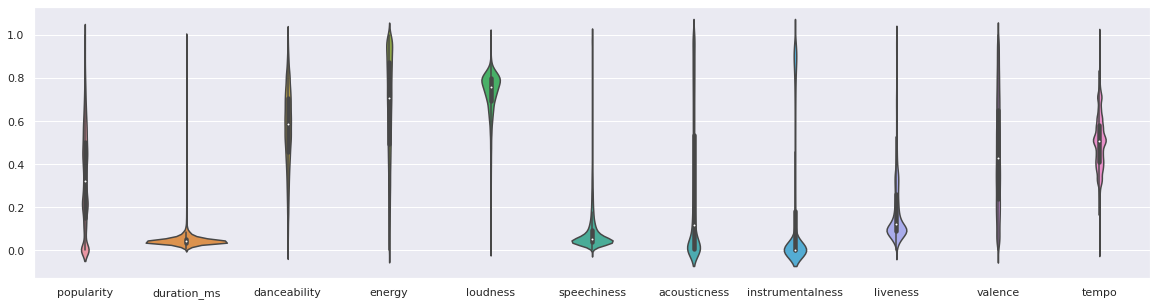

In [ ]:
#Distribution for each column with df_norm
sns.set(rc={'figure.figsize':(20,5)})
sns.violinplot(data = df_norm)

According to our violin plot, our columns are not normally distributed. So it's better to use min-max normalized dataset for our futhur analysis.

# PCA

In [ ]:
# Remove duplicate row to ensure the validity of PCA and clustering
df_norm_nodup = df_norm.drop_duplicates(keep="first")
df_norm_nodup[df_norm_nodup.duplicated()]

Empty DataFrame
Columns: [popularity, duration_ms, danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo]
Index: []

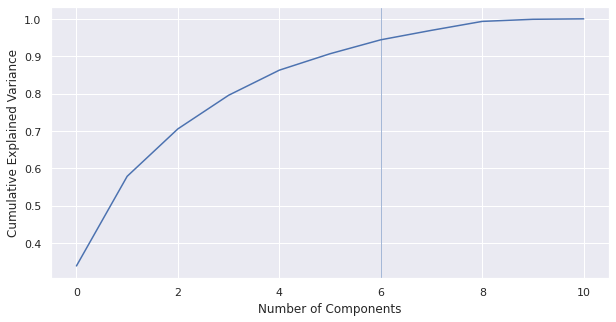

In [ ]:
# Variance explained
sns.set(rc={'figure.figsize':(10,5)})
ax = plt.figure().gca()
pca = PCA().fit(df_norm_nodup)
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.axvline(x=6, linewidth=1, color='b', alpha=0.5)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

With number of components = 6, about 95% of variance in data are captured.

In [ ]:
n_components = 6
pca = PCA(n_components=n_components)
pca_fit = pca.fit_transform(df_norm_nodup)
df_pca = pd.DataFrame(data = pca_fit
             , columns = ['PC '+ str(i+1) for i in range(n_components)])
df_pca.head()

PC 1      PC 2      PC 3      PC 4      PC 5      PC 6
0 -0.254917 -0.279866  0.086114 -0.202716  0.307452  0.131990
1  0.702546 -0.500827 -0.265958 -0.166791  0.016009 -0.039119
2  0.114221 -0.105012 -0.404890 -0.322972 -0.019535  0.108419
3  0.755717 -0.457642 -0.452111 -0.274767  0.103361 -0.218645
4  0.195461 -0.281565 -0.317403 -0.426116  0.209098  0.080626

# Clustering

### **K-Means**

In [ ]:
wcss = []

for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 12)
    kmeans.fit(df_pca)
    wcss.append(kmeans.inertia_)

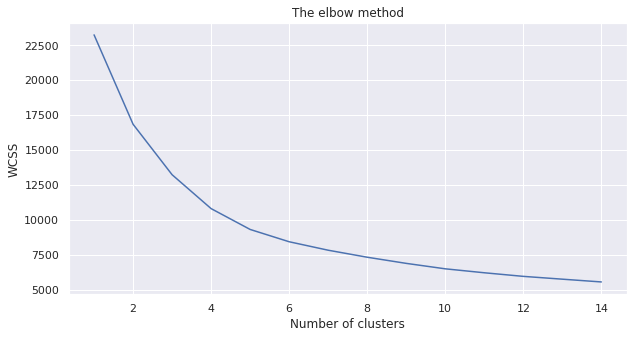

In [ ]:
plt.plot(range(1, 15), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 8, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 12)
y_kmeans = kmeans.fit_predict(df_pca)

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(n_init=10, random_state=12))

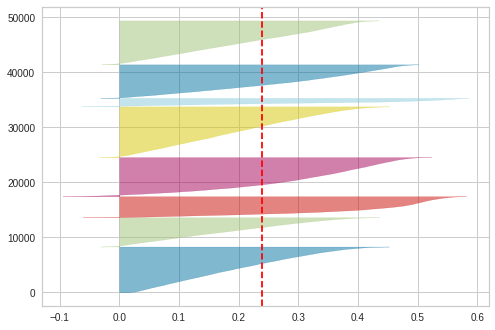

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

km = KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, random_state=12)
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(df_pca) 

The Silhouette score of the K-means above is around 0.25, which is not very good clustering performance. We will include categorical variables and try K-modes to see the performance.

### **K-modes**

In [ ]:
# Drop duplicate rows
spotify_new_norm_nodup = spotify_new_norm.drop(columns=["track_genre"])
spotify_new_norm_nodup = spotify_new_norm_nodup.drop_duplicates(subset=['popularity',
                                                                        'duration_ms',
                                                                        'danceability',
                                                                        'energy',
                                                                        'loudness',
                                                                        'speechiness',
                                                                        'acousticness',
                                                                        'instrumentalness',
                                                                        'liveness',
                                                                        'valence',
                                                                        'tempo'],keep="first")
spotify_new_norm_nodup[spotify_new_norm_nodup.duplicated()]

In [ ]:
spotify_new_norm_nodup = spotify_new_norm_nodup.dropna()

In [ ]:
spotify_new_norm_nodup.isna().sum()

artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
danceability        0
energy              0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
dtype: int64

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1176779.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 1176779.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 1176779.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 1176779.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 1176779.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 158, cost: 1175707.0
Run 1, iteration: 2/100, moves: 12, cost: 1175707.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 131, cost: 1175683.0
Init:

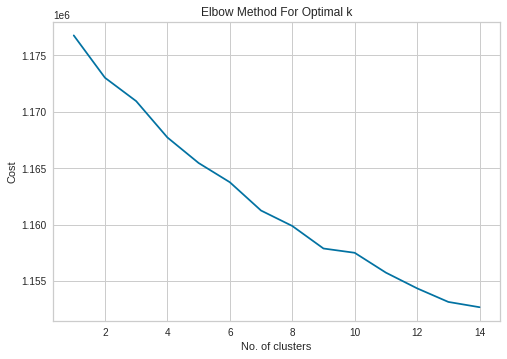

In [ ]:
# Elbow curve to find optimal K
cost = []
K = range(1,15)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1, random_state = 45)
    kmode.fit_predict(spotify_new_norm_nodup)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

# Recommender System

## Popularity Based

In [ ]:
spotify_new_norm_nodup = spotify_new_norm.drop(columns=["track_genre"])
spotify_new_norm_nodup = spotify_new_norm_nodup.drop_duplicates(subset=['popularity',
                                                                        'duration_ms',
                                                                        'danceability',
                                                                        'energy',
                                                                        'loudness',
                                                                        'speechiness',
                                                                        'acousticness',
                                                                        'instrumentalness',
                                                                        'liveness',
                                                                        'valence',
                                                                        'tempo'],keep="first")

In [ ]:
kmeans_recom = df_pca.copy()
kmeans_recom['KMeans'] = pd.Series(kmeans.labels_, index=kmeans_recom.index)
kmeans_recom["artists"] = list(spotify_new_norm_nodup["artists"])
kmeans_recom["album_name"] = list(spotify_new_norm_nodup["album_name"])
kmeans_recom["track_name"] = list(spotify_new_norm_nodup["track_name"])
kmeans_recom["popularity"] = list(spotify_new_norm_nodup["popularity"])
kmeans_recom

PC 1      PC 2      PC 3      PC 4      PC 5      PC 6  KMeans  \
0     -0.283768 -0.194557  0.029677 -0.186786  0.337758  0.214574       5   
1      0.695475 -0.430115 -0.246120 -0.190896  0.062036 -0.014147       6   
2      0.123618 -0.011200 -0.421784 -0.317944  0.018143  0.128515       5   
3      0.757730 -0.375022 -0.430916 -0.262042  0.166602 -0.186921       6   
4      0.194459 -0.176276 -0.328651 -0.416924  0.256803  0.054657       5   
...         ...       ...       ...       ...       ...       ...     ...   
86700  0.915233  0.582033 -0.042482 -0.013592 -0.083992 -0.147787       7   
86701  1.251195  0.424259  0.008592  0.040542 -0.030002 -0.134970       7   
86702  0.390722 -0.543288  0.243379  0.001460 -0.152928 -0.082154       0   
86703  0.047318 -0.172753 -0.127904 -0.046793  0.019646  0.057041       5   
86704  0.221123 -0.405305  0.158670  0.027115 -0.156188 -0.088317       0   

                      artists  \
0                 Gen Hoshino   
1                Ben Woodward   
2      Ingrid Michaelson;ZAYN   
3                Kina Grannis   
4            Chord Overstreet   
...                       ...   
86700           Rainy Lullaby   
86701           Rainy Lullaby   
86702           Cesária Evora   
86703        Michael W. Smith   
86704           Cesária Evora   

                                              album_name  \
0                                                 Comedy   
1                                       Ghost (Acoustic)   
2                                         To Begin Again   
3      Crazy Rich Asians (Original Motion Picture Sou...   
4                                                Hold On   
...                                                  ...   
86700  #mindfulness - Soft Rain for Mindful Meditatio...   
86701  #mindfulness - Soft Rain for Mindful Meditatio...   
86702                                            Best Of   
86703                                  Change Your World   
86704                                     Miss Perfumado   

                       track_name  popularity  
0                          Comedy        0.73  
1                Ghost - Acoustic        0.55  
2                  To Begin Again        0.57  
3      Can't Help Falling In Love        0.71  
4                         Hold On        0.82  
...                           ...         ...  
86700         Sleep My Little Boy        0.21  
86701            Water Into Light        0.22  
86702              Miss Perfumado        0.22  
86703                     Friends        0.41  
86704                   Barbincor        0.22  

[86705 rows x 11 columns]

In [ ]:
'''
function for printing out recommended song based on user's input of album and track name
'''
data = kmeans_recom
def get_cluster_popu_song(album,track):

    # check user input validity
    if album not in list(data["album_name"]) and track not in list(data["track_name"]):
        print("Cannot find your song, please try again")
        return

    # get input song cluster number
    group_num = int(data[(data["album_name"]==album) & (data["track_name"]==track)]["KMeans"])
    # get current cluster max popularity
    max_popu = data[data["KMeans"]==group_num]["popularity"].max()

    # find recommended song with max popularity
    song = data[data["popularity"]==max_popu]
    if len(song["album_name"])>1:
        song = song.sample()

    print("Base on your favorite song style and popularity, ")
    print("Your next recommended album name is ",song["album_name"].to_string(index=False) )
    print("Your next recommended track name is ",song["track_name"].to_string(index=False) )
    print("Your next recommended artist is ",song["artists"].to_string(index=False) )

In [ ]:
import time
print("=======================================================")
print("Welcome to Spotify Recommender System.")
print("=======================================================")
print()

while True:
    print()
    print("******************** Main Page ********************")
    print("Enter \"quit\" at any time to exit the system.")
    time.sleep(1)
    print("Please enter an album name.")
    
    str_album = input("")
    
    if str_album == "quit":
        break
    
    print("Please enter a track name.")
    str_track = input("")
    
    if str_track == "quit":
        break
    
    str_lst = [str_album, str_track]
    
    #function here
    print("\nStart recommending ... Please wait...\n")
    time.sleep(1)
    get_cluster_popu_song(str_album,str_track)

Welcome to Spotify Recommender System.


******************** Main Page ********************
Enter "quit" at any time to exit the system.
Please enter an album name.
The Light Meets The Dark
Please enter a track name.
Healing Begins

Start recommending ... Please wait...

Base on your favorite song style and popularity, 
Your next recommended album name is  Unholy (feat. Kim Petras)
Your next recommended track name is  Unholy (feat. Kim Petras)
Your next recommended artist is  Sam Smith;Kim Petras

******************** Main Page ********************
Enter "quit" at any time to exit the system.
Please enter an album name.
The Light Meets The Dark
Please enter a track name.
Healing Begins

Start recommending ... Please wait...

Base on your favorite song style and popularity, 
Your next recommended album name is  Unholy (feat. Kim Petras)
Your next recommended track name is  Unholy (feat. Kim Petras)
Your next recommended artist is  Sam Smith;Kim Petras

******************** Main Page **

## Content Based

In [ ]:
#construct non-duplicates dataset (with dummies) for recommendation
spotify_new_dummy = pd.get_dummies(spotify_new, prefix=["track_genre"], columns=["track_genre"], drop_first=True)
df = spotify_new_dummy.groupby(by=list(spotify_new.columns)[3:14]).sum().reset_index()
spotify_new_nodup = spotify_new.drop(columns=["track_genre"])
spotify_new_nodup = spotify_new_nodup.drop_duplicates(subset=['popularity',
                                                                        'duration_ms',
                                                                        'danceability',
                                                                        'energy',
                                                                        'loudness',
                                                                        'speechiness',
                                                                        'acousticness',
                                                                        'instrumentalness',
                                                                        'liveness',
                                                                        'valence',
                                                                        'tempo'],keep="first")
spotify_new_nodup = spotify_new_nodup.reset_index(drop = True)
df = pd.concat([spotify_new_nodup.iloc[:,:3],df],axis = 1)
df

artists  \
0                 Gen Hoshino   
1                Ben Woodward   
2      Ingrid Michaelson;ZAYN   
3                Kina Grannis   
4            Chord Overstreet   
...                       ...   
49360               Nima A.M.   
49361           Rojin Sharafi   
49362              Leila Bela   
49363                 Idlefon   
49364             Arash Azadi   

                                              album_name  \
0                                                 Comedy   
1                                       Ghost (Acoustic)   
2                                         To Begin Again   
3      Crazy Rich Asians (Original Motion Picture Sou...   
4                                                Hold On   
...                                                  ...   
49360                                      The Frequency   
49361                             Urns Waiting To Be Fed   
49362                                        Angra Manyu   
49363                                         COLDSTREAM   
49364                             Mathematical Labyrinth   

                       track_name  popularity  duration_ms  danceability  \
0                          Comedy           0         8586         0.000   
1                Ghost - Acoustic           0        13386         0.000   
2                  To Begin Again           0        15800         0.251   
3      Can't Help Falling In Love           0        17453         0.467   
4                         Hold On           0        17826         0.372   
...                           ...         ...          ...           ...   
49360                Love in Fall          93       244360         0.445   
49361          The Last Urn Broke          96       184613         0.733   
49362                 Going Under          98       175238         0.561   
49363                       Wreck          99       198937         0.621   
49364                   Se + F=Ph         100       156943         0.714   

       energy  loudness  speechiness  acousticness  instrumentalness  \
0      0.0400   -29.714       0.0000       0.92800          0.956000   
1      0.2240   -22.196       0.0000       0.97000          0.000000   
2      0.5080   -10.564       0.3160       0.96900          0.999000   
3      0.0301   -28.518       0.0428       0.99500          0.900000   
4      0.2780   -16.882       0.0370       0.98500          0.921000   
...       ...       ...          ...           ...               ...   
49360  0.5370    -8.532       0.0400       0.69500          0.000017   
49361  0.6900    -5.529       0.0427       0.06350          0.000001   
49362  0.9650    -3.673       0.0343       0.00383          0.000007   
49363  0.7820    -5.548       0.0440       0.01250          0.033000   
49364  0.4720    -7.375       0.0864       0.01300          0.000005   

       liveness  valence    tempo  track_genre_afrobeat  track_genre_alt-rock  \
0        0.1150    0.000    0.000                     0                     0   
1        0.9070    0.000    0.000                     0                     0   
2        0.9520    0.000  184.051                     0                     0   
3        0.1240    0.000   84.375                     0                     0   
4        0.1640    0.912   89.032                     0                     0   
...         ...      ...      ...                   ...                   ...   
49360    0.0944    0.131  122.769                     0                     0   
49361    0.1050    0.310  116.992                     0                     0   
49362    0.3710    0.304  128.040                     0                     0   
49363    0.2300    0.550  128.033                     0                     0   
49364    0.2660    0.238  131.121                     0                     0   

       track_genre_alternative  track_genre_ambient  track_genre_anime  \
0                            0                    0                  0   
1    

In [ ]:
def getSubjectivity(text):
    '''
    Getting the Subjectivity using TextBlob
    '''
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    '''
    Getting the Polarity using TextBlob
    '''
    return TextBlob(text).sentiment.polarity

def getAnalysis(score, task="polarity"):
    '''
    Categorizing the Polarity & Subjectivity score
    '''
    if task == "subjectivity":
        if score < 1/3:
            return "low"
        elif score > 1/3:
            return "high"
        else:
            return "medium"
    else:
        if score < 0:
            return 'Negative'
        elif score == 0:
            return 'Neutral'
        else:
            return 'Positive'

def sentiment_analysis(df, text_col):
    '''
    Perform sentiment analysis on text
    ---
    Input:
    df (pandas dataframe): Dataframe of interest
    text_col (str): column of interest
    '''
    df['subjectivity'] = df[text_col].apply(getSubjectivity).apply(lambda x: getAnalysis(x,"subjectivity"))
    df['polarity'] = df[text_col].apply(getSubjectivity).apply(lambda x: getAnalysis(x,"polarity"))
    return df

In [ ]:
def feature_engineer(df):
    #Feature Engineering: sentiment analysis on text column
    df_dummy = sentiment_analysis(df, 'track_name')
    df_dummy = pd.get_dummies(df_dummy, prefix=["subjectivity"], columns=["subjectivity"])
    df_dummy = pd.get_dummies(df_dummy,prefix=['polarity'],columns = ['polarity'])
    
    #Min-Max Normalization
    scaler = MinMaxScaler()
    df_dummy.iloc[:,3:14] = pd.DataFrame(scaler.fit_transform(df_dummy.iloc[:,3:14]), columns=df_dummy.iloc[:,3:14].columns)
    return df_dummy

df_dummy = feature_engineer(df)
df_dummy

artists  \
0                 Gen Hoshino   
1                Ben Woodward   
2      Ingrid Michaelson;ZAYN   
3                Kina Grannis   
4            Chord Overstreet   
...                       ...   
49360               Nima A.M.   
49361           Rojin Sharafi   
49362              Leila Bela   
49363                 Idlefon   
49364             Arash Azadi   

                                              album_name  \
0                                                 Comedy   
1                                       Ghost (Acoustic)   
2                                         To Begin Again   
3      Crazy Rich Asians (Original Motion Picture Sou...   
4                                                Hold On   
...                                                  ...   
49360                                      The Frequency   
49361                             Urns Waiting To Be Fed   
49362                                        Angra Manyu   
49363                                         COLDSTREAM   
49364                             Mathematical Labyrinth   

                       track_name  popularity  duration_ms  danceability  \
0                          Comedy        0.00     0.000000      0.000000   
1                Ghost - Acoustic        0.00     0.001004      0.000000   
2                  To Begin Again        0.00     0.001509      0.255341   
3      Can't Help Falling In Love        0.00     0.001855      0.475076   
4                         Hold On        0.00     0.001933      0.378433   
...                           ...         ...          ...           ...   
49360                Love in Fall        0.93     0.049321      0.452696   
49361          The Last Urn Broke        0.96     0.036822      0.745677   
49362                 Going Under        0.98     0.034861      0.570702   
49363                       Wreck        0.99     0.039819      0.631740   
49364                   Se + F=Ph        1.00     0.031034      0.726348   

         energy  loudness  speechiness  acousticness  instrumentalness  \
0      0.039981  0.264729     0.000000      0.931727          0.956957   
1      0.223984  0.426142     0.000000      0.973896          0.000000   
2      0.507990  0.675885     0.327461      0.972892          1.000000   
3      0.030080  0.290407     0.044352      0.998996          0.900901   
4      0.277985  0.540235     0.038342      0.988956          0.921922   
...         ...       ...          ...           ...               ...   
49360  0.536991  0.719512     0.041451      0.697791          0.000017   
49361  0.689994  0.783987     0.044249      0.063755          0.000001   
49362  0.964999  0.823836     0.035544      0.003845          0.000007   
49363  0.781996  0.783580     0.045596      0.012550          0.033033   
49364  0.471989  0.744353     0.089534      0.013052          0.000005   

       liveness   valence     tempo  track_genre_afrobeat  \
0      0.105509  0.000000  0.000000                     0   
1      0.910551  0.000000  0.000000                     0   
2      0.956292  0.000000  0.756254                     0   
3      0.114657  0.000000  0.346691                     0   
4      0.155316  0.916583  0.365827                     0   
...         ...       ...       ...                   ...   
49360  0.084570  0.131658  0.504450                     0   
49361  0.095345  0.311558  0.480713                     0   
49362  0.365725  0.305528  0.526108                     0   
49363  0.222403  0.552764  0.526079                     0   
49364  0.258996  0.239196  0.538768                     0   

       track_genre_alt-rock  track_genre_alternative  track_genre_ambient  \
0                         0                        0                    0   
1                         0                        0                    0   
2                         0                        0                    0   
3                         0                        0         

In [ ]:
def get_similar_content_song(df,album,track):
    df_new = df.copy()
    #index to certain row
    if album not in list(df_new["album_name"]) and track not in list(df_new["track_name"]):
        print("Cannot find your song, please try again")
        return
    else:
        index_ = df_new[(df_new['album_name']==album)&(df_new['track_name']==track)].index
    
        #obtain features of input song and nonlist song
        features = df_new.iloc[index_[0],3:]
        df_new.drop(index_[0], inplace=True)
        nonlist_features = df_new.iloc[:,3:]

        # Find cosine similarity between the playlist and the complete song set
        df_new['sim'] = cosine_similarity(nonlist_features.values, features.values.reshape(1, -1))
        non_playlist_df_top_1= df_new.sort_values('sim',ascending = False).head(1)

        print("Base on your favorite song style, ")
        print("Your next recommended album name is ",non_playlist_df_top_1["album_name"].to_string(index=False) )
        print("Your next recommended track name is ",non_playlist_df_top_1["track_name"].to_string(index=False) )
        print("Your next recommended artist is ",non_playlist_df_top_1["artists"].to_string(index=False) )

In [ ]:
import time
print("=======================================================")
print("Welcome to Spotify Recommender System.")
print("=======================================================")
print()

while True:
    print()
    print("******************** Main Page ********************")
    print("Enter \"quit\" at any time to exit the system.")
    time.sleep(1)
    print("Please enter an album name.")
    
    str_album = input("")
    
    if str_album == "quit":
        break
    
    print("Please enter a track name.")
    str_track = input("")
    
    if str_track == "quit":
        break
    
    str_lst = [str_album, str_track]
    
    #function here
    print("\nStart recommending ... Please wait...\n")
    time.sleep(1)
    get_similar_content_song(df_dummy,str_album,str_track)
    
print("\nThanks for using our song recommeder system. Hope you enjoy your next song.")

Welcome to Spotify Recommender System.


******************** Main Page ********************
Enter "quit" at any time to exit the system.
Please enter an album name.
Comedy
Please enter a track name.
Comedy

Start recommending ... Please wait...

Base on your favorite song style, 
Your next recommended album name is  Flow en Cuarentena
Your next recommended track name is  Mi perro vive mejor que tú (feat. Kronno Zomber)
Your next recommended artist is  Zarcort;Kronno Zomber

******************** Main Page ********************
Enter "quit" at any time to exit the system.
Please enter an album name.
skskskjkskss
Please enter a track name.
sksksksksks

Start recommending ... Please wait...

Cannot find your song, please try again

******************** Main Page ********************
Enter "quit" at any time to exit the system.
Please enter an album name.
quit

Thanks for using our song recommeder system. Hope you enjoy your next song.
